### Analyzing campaigns

textbook from [course](https://www.datacamp.com/courses/analyzing-marketing-campaigns-with-pandas)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

marketing = pd.read_csv('marketing.csv', 
            parse_dates=['date_served', 'date_subscribed', 'date_canceled'])

marketing['DoW'] = marketing.date_subscribed.dt.dayofweek
marketing['is_retained'] = marketing['is_retained'].astype('bool')
marketing['converted'] = marketing['converted'].astype('bool')

marketing['is_correct_lang'] = np.where(marketing.language_displayed == 
                                   marketing.language_preferred, True, False)

In [2]:
marketing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10037 entries, 0 to 10036
Data columns (total 14 columns):
user_id                10037 non-null object
date_served            10021 non-null datetime64[ns]
marketing_channel      10022 non-null object
variant                10037 non-null object
converted              10037 non-null bool
language_displayed     10037 non-null object
language_preferred     10037 non-null object
age_group              10037 non-null object
date_subscribed        1856 non-null datetime64[ns]
date_canceled          577 non-null datetime64[ns]
subscribing_channel    1856 non-null object
is_retained            10037 non-null bool
DoW                    1856 non-null float64
is_correct_lang        10037 non-null bool
dtypes: bool(3), datetime64[ns](3), float64(1), object(7)
memory usage: 892.1+ KB


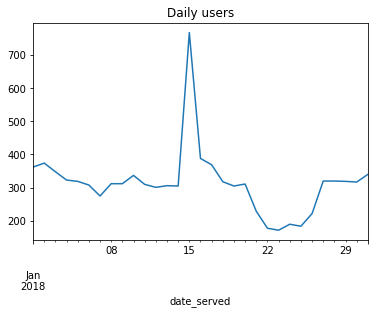

In [3]:
daily_users = marketing.groupby(['date_served'])['user_id'].nunique()
daily_users.plot(title='Daily users');

Common metrics of measuring campaign's success:<br>
- conversion rate (how many subscribed?)<br>
- retetntion rate (how many stayed?)

In [4]:
total = marketing.user_id.nunique()
subscribers = marketing[marketing.converted].user_id.nunique()
conversion_rate = subscribers / total
print('Conversion rate', round(conversion_rate*100, 2), "%")

retained = marketing[marketing.is_retained & marketing.converted].user_id.nunique()
retention_rate = retained / subscribers
print('Retention rate', round(retention_rate*100, 2), "%")

Conversion rate 14.09 %
Retention rate 67.57 %


### Customer segmentation

In [5]:
subscribed = marketing[marketing.converted].groupby('subscribing_channel').\
        user_id.nunique()
retained = marketing[marketing.is_retained].groupby('subscribing_channel').\
        user_id.nunique()
retention_rate = (retained / subscribed) * 100
print('Retention rate by channel\n\n', round(retention_rate, 2))

Retention rate by channel

 subscribing_channel
Email        87.58
Facebook     68.78
House Ads    58.05
Instagram    68.10
Push         70.13
Name: user_id, dtype: float64


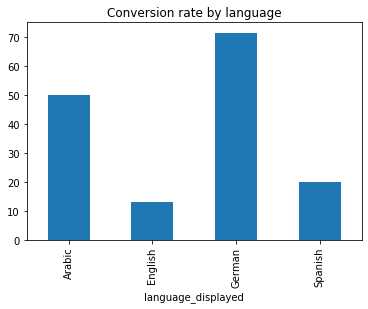

In [6]:
total = marketing.groupby('language_displayed').user_id.nunique()
subscribers = marketing[marketing.converted].groupby('language_displayed').\
        user_id.nunique()
language_conversion_rate = subscribers / total *100
language_conversion_rate.plot(kind='bar', title='Conversion rate by language');

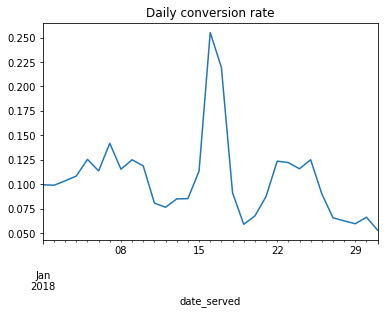

In [7]:
total = marketing.groupby('date_served').user_id.nunique()
subscribers = marketing[marketing.converted].groupby('date_served')\
        .user_id.nunique()
daily_conversion_rate = subscribers/total
daily_conversion_rate.plot(title='Daily conversion rate');

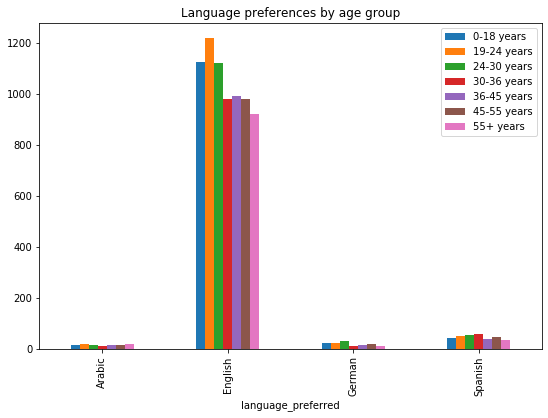

In [8]:
lang_age = marketing.groupby(['language_preferred', 'age_group']).\
        user_id.nunique()
lang_age = pd.DataFrame(lang_age.unstack(level=1))
lang_age.plot(kind='bar', title='Language preferences by age group', 
              figsize=(9,6))
plt.legend(loc='upper right', 
          labels=lang_age.columns.values);

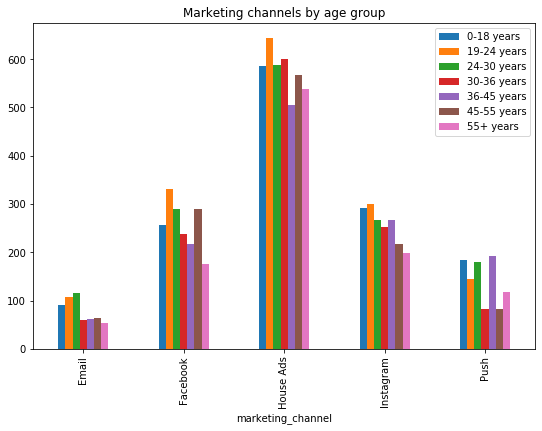

In [9]:
channel_age = marketing.groupby(['marketing_channel', 'age_group'])\
                                ['user_id'].nunique()
channel_age_df = pd.DataFrame(channel_age.unstack(level = 1))
channel_age_df.plot(kind = 'bar', title='Marketing channels by age group',
                    figsize=(9,6))
plt.legend(loc = 'upper right', 
           labels = channel_age_df.columns.values);

In [10]:
def conversion_rate(dataframe, column_names):
    column_conv = dataframe[dataframe['converted']].\
            groupby(column_names).user_id.nunique()
    column_total = dataframe.groupby(column_names).user_id.nunique() 
    conversion_rate = column_conv/column_total
    conversion_rate = conversion_rate.fillna(0)
    return conversion_rate

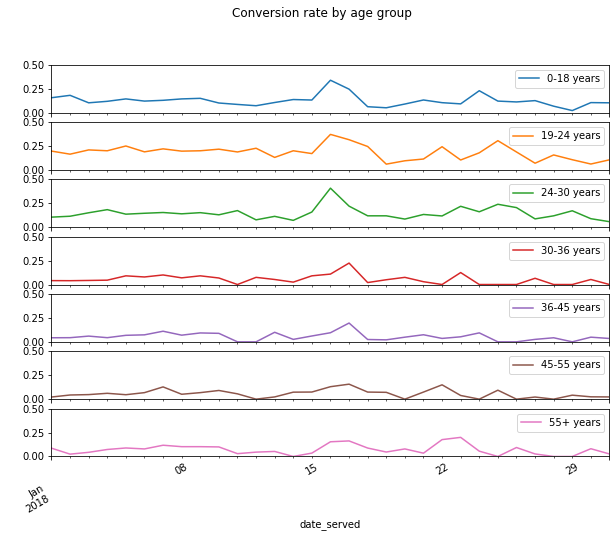

In [12]:
age_group_conv = conversion_rate(marketing, ['date_served', 'age_group'])
age_group_df = pd.DataFrame(age_group_conv.unstack(level=1))
age_group_df.plot(title='Conversion rate by age group', figsize=(10,8), 
                  subplots=True, ylim=(0,0.5));

### A/B testing

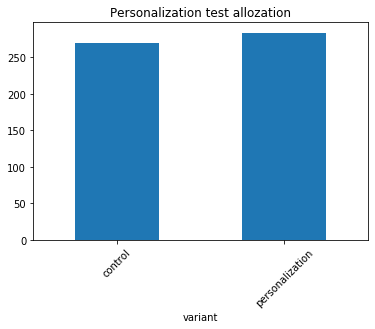

In [24]:
email = marketing[marketing.marketing_channel == 'Email']
allocation = email.groupby('variant').user_id.nunique()
allocation.plot(kind='bar', title='Personalization test allozation')
plt.xticks(rotation=45);

In [26]:
subscribers = email.groupby(['user_id','variant']).converted.max()
subscribers_df = pd.DataFrame(subscribers.unstack(level=1)) 

control = subscribers_df.control.dropna()
personalization = subscribers_df.personalization.dropna()
print('Control conversion rate:', control.mean())
print('Personalization conversion rate:', personalization.mean())

Control conversion rate: 0.2814814814814815
Personalization conversion rate: 0.3908450704225352


In [33]:
# lift
def lift(a,b):
    a_mean = np.mean(a)
    b_mean = np.mean(b)
    lift = (b_mean-a_mean)/a_mean
    return str(round(lift*100, 2)) + '%'
  
print('lift:', lift(control, personalization))

lift: 38.85%


In [36]:
from scipy.stats import ttest_ind
t = ttest_ind(control, personalization)
print(t)
print('\nStatistically', 'significant' if t[1]<0.05 else 'unsignificant')

Ttest_indResult(statistic=-2.7343299447505074, pvalue=0.0064514878446941745)

Statistically significant


In [46]:
def ab_segmentation(segment):
  for subsegment in np.unique(marketing[segment].values):
      print(subsegment)
       
      email = marketing[(marketing['marketing_channel'] == 'Email') & (marketing[segment] == subsegment)]

      subscribers = email.groupby(['user_id', 'variant'])['converted'].max()
      subscribers = pd.DataFrame(subscribers.unstack(level=1)) 
      control = subscribers['control'].dropna()
      personalization = subscribers['personalization'].dropna()

      print('lift:', lift(control, personalization))
      t = ttest_ind(control, personalization)
      print(t)
      print('Statistically', 'significant\n' if t[1]<0.05 else 'unsignificant\n')

In [47]:
ab_segmentation('language_displayed')

Arabic
lift: 50.0%
Ttest_indResult(statistic=-0.5773502691896255, pvalue=0.5795840000000001)
Statistically unsignificant

English
lift: 39.0%
Ttest_indResult(statistic=-2.2183598646203166, pvalue=0.026991701290720815)
Statistically significant

German
lift: -1.62%
Ttest_indResult(statistic=0.1910083418078718, pvalue=0.8494394170062678)
Statistically unsignificant

Spanish
lift: 166.67%
Ttest_indResult(statistic=-2.3570226039551585, pvalue=0.040156718110477524)
Statistically significant



In [48]:
ab_segmentation('age_group')

0-18 years
lift: 121.4%
Ttest_indResult(statistic=-2.966044912142211, pvalue=0.0038724494391297226)
Statistically significant

19-24 years
lift: 106.24%
Ttest_indResult(statistic=-3.03179438478667, pvalue=0.0030623836114689134)
Statistically significant

24-30 years
lift: 161.19%
Ttest_indResult(statistic=-3.861539544326876, pvalue=0.00018743381094867335)
Statistically significant

30-36 years
lift: -100.0%
Ttest_indResult(statistic=3.1859064644147996, pvalue=0.0023238487431765137)
Statistically significant

36-45 years
lift: -85.23%
Ttest_indResult(statistic=2.4317901279318503, pvalue=0.017975686009788286)
Statistically significant

45-55 years
lift: -72.22%
Ttest_indResult(statistic=2.065499127317933, pvalue=0.043062339688201196)
Statistically significant

55+ years
lift: -100.0%
Ttest_indResult(statistic=3.3265654564203397, pvalue=0.0016358623456360435)
Statistically significant

